Optimised version of the network that we are going to use for the MNIST classification exercise

In [16]:
import numpy as np

import matplotlib.pyplot as plt 

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms 
from torchvision.transforms import ToTensor
import torch.nn as nn 
import torch.nn.functional as F

In [17]:
custom_train_transform = transforms.Compose([
    transforms.ToTensor(),  # Converts image to a PyTorch tensor
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),  # Apply Gaussian blur
    transforms.RandomRotation(degrees=30),  # Apply random rotation (range: -30 to +30 degrees)
])
custom_val_transform = transforms.Compose([
    transforms.ToTensor() # Converts image to a PyTorch tensor
])

In [18]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=custom_train_transform
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=custom_val_transform
)

In [19]:
class Griff_CNN(nn.Module):
    def __init__(self):
        super(Griff_CNN, self).__init__()

        # First convolutional layer + batch normalization
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional layer + batch normalization
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(24)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers with dropout
        self.fc1 = nn.Linear(in_features=24*7*7, out_features=512)
        self.dropout1 = nn.Dropout(0.5)  # Dropout with 50% probability
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(in_features=256, out_features=10)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [20]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

model = Griff_CNN().to(device)

Using mps device


In [21]:
def train_loop(dataloader, model, loss_fn, optimizer, history, device):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()

    train_loss, correct_guesses = 0., 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # forward prediction
        pred = model(X) 
        loss = loss_fn(pred, y)
        correct = (pred.argmax(1) == y).type(torch.float).sum().item()

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() 
        correct_guesses += correct 

        if batch % 100 == 0:
            current = batch * len(X)
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= num_batches 
    correct_guesses /= size

    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(correct_guesses)

In [22]:
def test_loop(dataloader, model, loss_fn, history, device):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0., 0. 

    with torch.no_grad(): 
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X) 
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches 
    correct /= size 
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    history['val_loss'].append(test_loss)
    history['val_accuracy'].append(correct)

In [23]:
loss_fn = nn.CrossEntropyLoss()

batchsize = 64 # mini-batch size 
nworkers = 4
lr = 1.0e-3 # learning rate
epochs = 50 # number of training epochs 

# ADAM optimizer parameters
beta1 = 0.9 
beta2 = 0.999 
eps = 1.0e-8
lambd = 1.0e-5

In [24]:
# Define optimiser
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=lr, 
                             betas=(beta1, beta2), 
                             eps=eps, 
                             weight_decay=lambd)

train_dataloader = DataLoader(training_data, batch_size=batchsize, num_workers=nworkers)
test_dataloader = DataLoader(test_data, batch_size=batchsize, num_workers=nworkers)

In [25]:
history = {'epoch' : [], 
           'train_loss' : [],
           'train_accuracy' : [],
           'val_loss': [],
           'val_accuracy' : []
}

In [26]:
# # Can we see what happens when the network is fully untrained?
# history['epoch'].append(0)
# test_loop(train_dataloader, model, loss_fn, history, device)
# history['train_loss'].append(history['val_loss'][0])
# history['train_accuracy'].append(history['val_accuracy'][0])
# history['val_loss'].pop(0)
# history['val_accuracy'].pop(0)
# test_loop(test_dataloader, model, loss_fn, history, device)


In [27]:
print(history)

{'epoch': [], 'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}


In [28]:

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    history['epoch'].append(t+1)
    train_loop(train_dataloader, model, loss_fn, optimizer, history, device)
    test_loop(test_dataloader, model, loss_fn, history, device)
print("Done!")

Epoch 1
-------------------------------
loss: 2.295365  [    0/60000]
loss: 0.457318  [ 6400/60000]
loss: 0.318976  [12800/60000]
loss: 0.213961  [19200/60000]
loss: 0.341194  [25600/60000]
loss: 0.280037  [32000/60000]
loss: 0.232697  [38400/60000]
loss: 0.296198  [44800/60000]
loss: 0.221621  [51200/60000]
loss: 0.219938  [57600/60000]
Test Error: 
 Accuracy: 97.2%, Avg loss: 0.094119 

Epoch 2
-------------------------------
loss: 0.245648  [    0/60000]
loss: 0.162629  [ 6400/60000]
loss: 0.144114  [12800/60000]
loss: 0.170419  [19200/60000]
loss: 0.044211  [25600/60000]
loss: 0.293533  [32000/60000]
loss: 0.070057  [38400/60000]
loss: 0.211274  [44800/60000]
loss: 0.311259  [51200/60000]
loss: 0.239832  [57600/60000]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.066459 

Epoch 3
-------------------------------
loss: 0.099473  [    0/60000]
loss: 0.140905  [ 6400/60000]
loss: 0.138983  [12800/60000]
loss: 0.119208  [19200/60000]
loss: 0.023617  [25600/60000]
loss: 0.141050  [32000/600

In [29]:
history

{'epoch': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 'train_loss': [0.3376911865023058,
  0.17001271315925776,
  0.13815922714543463,
  0.12106235627147521,
  0.11102632843831708,
  0.10193054913766562,
  0.0969071685220363,
  0.09011849069908044,
  0.0842474860268638,
  0.08023813991412235,
  0.07669449120762818,
  0.07813005895576755,
  0.07146611011326824,
  0.07273342800344021,
  0.06740451781546448,
  0.06770056588036606,
  0.06500448436030239,
  0.06510642791894311,
  0.0630290410652355,
  0.06204817791662759,
  0.06238179620292568,
  0.05672468702865592,
  0.05803748850039502,
  0.05669188305693018,
  0.057633993192650335,
  0.05722562895412855,
  0.05844900953155984,
  0.053504793579475574,
  0.05284096275795443,
  0.0541721177179113

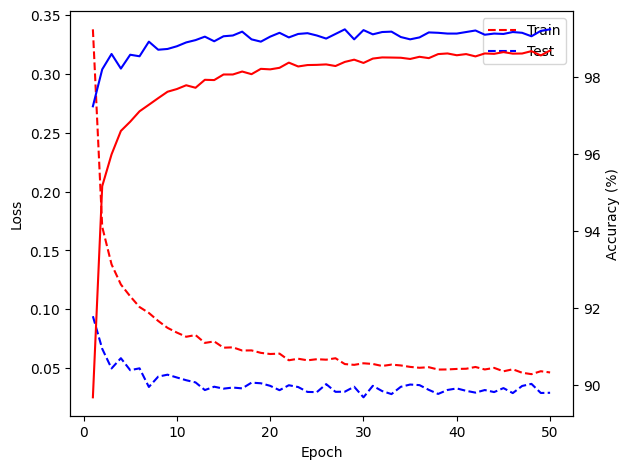

In [30]:
fig, ax = plt.subplots()
ax.plot(history['epoch'], history['train_loss'], color = 'red', linestyle = '--', label = 'Train')
ax.plot(history['epoch'], history['val_loss'], color = 'blue', linestyle = '--', label = "Test")
ax1 = ax.twinx()
ax1.plot(history['epoch'], 100*np.array(history['train_accuracy']), color = 'red', linestyle = '-')
ax1.plot(history['epoch'], 100*np.array(history['val_accuracy']), color = 'blue', linestyle = '-')

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax1.set_ylabel("Accuracy (%)")

ax.legend()

fig.tight_layout()